In [1]:
import spacy
from spacy.training import Example
from sklearn.model_selection import train_test_split
from spacy.util import minibatch  # Import minibatch

# Načtení základního modelu
nlp = spacy.blank("cs")

# Přidání pipeline komponenty NER
ner = nlp.add_pipe("ner")

In [2]:
import json

# Step 2: Open the JSON file
with open('generated_train_data/winery_ner_tagged_sentences.json', 'r', encoding='utf-8') as file:
    # Step 3: Load the JSON data
    data = json.load(file)
TRAINING_DATA = []
ner_labels = data["classes"]
for item in data["annotations"]:
    text = item[0].strip()  # Get the text and strip any extra whitespace
    entities = item[1]["entities"]
    
    # Create a dictionary for the current sentence's entities
    entities_formatted = {"entities": [(start, end, label) for start, end, label in entities]}
    
    # Append the tuple (text, entities) to the training data
    TRAINING_DATA.append((text, entities_formatted))

print(TRAINING_DATA)

[('název Dvořák Zdeněk mobil 420602820815 město Brno-Starý Lískovec emailová adresa lukas@vinotichy.cz adresa https://www.sonberk.cz/', {'entities': [(6, 19, 'VINAŘSTVÍ'), (45, 64, 'OBEC'), (81, 99, 'E-MAIL'), (26, 38, 'TELEFON'), (107, 130, 'WEB')]}), ('web http://www.stastnevinarstvi.cz/ e-mail kosulic@vinokosulic.cz jméno Hrušák Jaroslav město Sokolnice mobil 420775651555', {'entities': [(72, 87, 'VINAŘSTVÍ'), (94, 103, 'OBEC'), (43, 65, 'E-MAIL'), (110, 122, 'TELEFON'), (4, 35, 'WEB')]}), ('webová stránka https://vinopristal.cz/ název Janda Lubomír e-mail info@vinarstvibraunovi.cz telefon 420602510030 obec Ořechov', {'entities': [(45, 58, 'VINAŘSTVÍ'), (118, 125, 'OBEC'), (66, 91, 'E-MAIL'), (100, 112, 'TELEFON'), (15, 38, 'WEB')]}), ('e-mail info@vinarstvithaya.cz mobil 420777981544 město Telnice webová stránka http://www.tasovickevinarstvi.cz/ vinařství Černá Jitka', {'entities': [(122, 133, 'VINAŘSTVÍ'), (55, 62, 'OBEC'), (7, 29, 'E-MAIL'), (36, 48, 'TELEFON'), (78, 111, 'WEB')]

In [3]:
# Přidání labelů do NER
print(ner_labels)
for label in ner_labels:
    ner.add_label(label)
    # for ent in annotations.get("entities"):
    #     print(ent[2])
        # ner.add_label(ent[2])

['VINAŘSTVÍ', 'OBEC', 'E-MAIL', 'TELEFON', 'WEB']


In [4]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(TRAINING_DATA, test_size=0.2, random_state=42)

In [5]:
# Helper function to train the model
import random

def train_spacy_model(train_data, n_iter=10):
    optimizer = nlp.begin_training()
    
    for i in range(n_iter):
        random.shuffle(train_data)
        losses = {}
        batches = minibatch(train_data, size=8)
        for batch in batches:
            for text, annotations in batch:
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotations)
                nlp.update([example], drop=0.5, sgd=optimizer, losses=losses)
        print(f"Iteration {i+1}, Loss: {losses['ner']}")
    
    return nlp

# Začátek tréninku
# optimizer = nlp.begin_training()

# # Trénovací smyčka
# for i in range(10):  # Trénuj 10 epoch
#     for text, annotations in TRAINING_DATA2:
#         example = Example.from_dict(nlp.make_doc(text), annotations)
#         nlp.update([example], sgd=optimizer)

In [6]:
# Train the model
trained_nlp = train_spacy_model(train_data)
print(trained_nlp)
trained_nlp.to_disk("models/winery_ner_model")

Iteration 1, Loss: 929.834228515625
Iteration 2, Loss: 285.6005859375
Iteration 3, Loss: 193.64920043945312
Iteration 4, Loss: 138.8533935546875
Iteration 5, Loss: 83.39044952392578
Iteration 6, Loss: 49.17891311645508
Iteration 7, Loss: 32.34492492675781
Iteration 8, Loss: 31.743013381958008
Iteration 9, Loss: 19.301164627075195
Iteration 10, Loss: 19.136960983276367


In [7]:
import matplotlib.pyplot as plt
from spacy.scorer import Scorer

# Evaluate the model
def evaluate_model(nlp, test_data):
    examples = []
    for text, annotations in test_data:
        doc = nlp(text)
        example = Example.from_dict(doc, annotations)
        examples.append(example)
    
    # Scorer method expects a list of examples
    scores = nlp.evaluate(examples)
    return scores

In [8]:
# Get the evaluation metrics
scores = evaluate_model(trained_nlp, test_data)

# Extract precision, recall, and F1-score
precision = scores["ents_p"]
recall = scores["ents_r"]
f_score = scores["ents_f"]

print(precision)

1.0


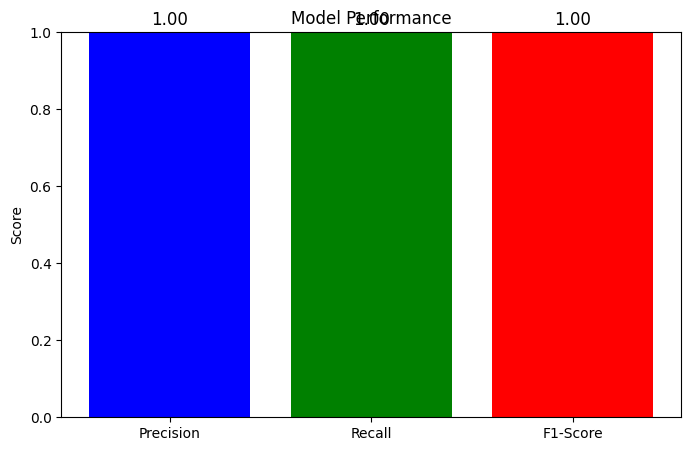

In [9]:
# Plot the results
def plot_metrics(precision, recall, f_score):
    metrics = ["Precision", "Recall", "F1-Score"]
    scores = [precision, recall, f_score]
    
    plt.figure(figsize=(8, 5))
    plt.bar(metrics, scores, color=['blue', 'green', 'red'])
    plt.ylim([0, 1])
    plt.title("Model Performance")
    plt.ylabel("Score")
    for i, score in enumerate(scores):
        plt.text(i, score + 0.02, f"{score:.2f}", ha='center', fontsize=12)
    plt.show()

# Plot the performance metrics
plot_metrics(precision, recall, f_score)